$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\piv}{\mathbf{\pi}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\gv}{\mathbf{g}}
\newcommand{\Hv}{\mathbf{H}}
\newcommand{\dv}{\mathbf{d}}
\newcommand{\Vv}{\mathbf{V}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\Sv}{\mathbf{S}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\Zv}{\mathbf{Z}}
\newcommand{\Norm}{\mathcal{N}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
$

## Research Questions

1) Does the difference between how much a presidential or US senate candidate raises vs their opponent tend to be larger or smaller when the race is against an incumbent vs when the race is between 2 non-incumbents?

  - Does being an incumbent amplify or diminish the impact of campaign spending?

2) How well does a logistic regression model that only controls for how much a campaign raises and whether they are an incumbent or not do to predict whether a presidential or US senate candidate will win?


## Presidential Data

### Election and Top-Level Finance Data

All US Presidential data used for the study was consolidated into a single tab delimited file named <span style="color:red; font-weight: bold">USPresidentialOverall.tsv</span>.  The first 8 columns of this spreadhseet were manually scraped from [from the FEC website](https://www.fec.gov/data/raising-bythenumbers/).  The data for the 9th and 10th columns were obtained [from the britannica.com website](https://www.britannica.com/topic/United-States-Presidential-Election-Results-1788863).

The file can be found in my git repo [here](https://raw.githubusercontent.com/MichaelSzczepaniak/CampaignFinance/master/data/USPresidentialOverall.tsv).

## Senate Data

### Historical Senate Election Results

Data for the historical US Senate races was obtained from the [MIT Election Data Science Lab](http://electionlab.mit.edu/) using the interface hosted by (Harvard Dataverse)[https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/PEJ5QU]

This study will only focus on top 2 candidates in presidential election years.  To ensure I was able to look at each senate race as essentially between 2 candidates, a couple of unusual races needed to be dealt with.  These two races are described below.

**[1984 Louisiana US Senate race](https://en.wikipedia.org/wiki/1984_United_States_Senate_election_in_Louisiana)** - Only a primary was held in the state.  Democratic incumbent Senator J. Bennett Johnston won the election with 85% of the vote and was declared elected by a majority, dispelling the need for a general election in November.  Data did not include the Republican challenger Robert M. Ross.  This name was manually inserted into the <span style="color:red">1980-2016-SenateElections.csv</span> file along with the <span style="color:red; font-weight: bold">primary</span> vote totals since there was no general election.

**[2004 Idaho US senate race](https://en.wikipedia.org/wiki/2004_United_States_Senate_election_in_Idaho)**  Data did not include the write-in democratic challenger Scott McClure.  This name and vote total was manually inserted into the <span style="color:red">1980-2016-SenateElections.csv</span> file.

### Historical Senate Campaign Financials

Headers for the senate financial data are described here:

https://www.fec.gov/campaign-finance-data/current-campaigns-house-and-senate-file-description/

Data for each US Senate race is in separate files downloaded from the FEC site.  The name of each file follows the format `weballyyyy.txt` where `yyyy` is the year.  These files are pipe (|) delimited.

These individual files are read and concatinated together before additional wrangling is done on them.

## Data Paths

The next cells creates paths to various data files used in the study.

In [1]:
import numpy as np
import pandas as pd

notebook_start_dir = './'  #'./Week09_10_FinalProject/'

pres_dir = notebook_start_dir + 'datasets/presidential/'
senate_dir = notebook_start_dir + 'datasets/senate/'

# presidential election and top-level finance data - 10 records, manually compiled
pres_overall_path = pres_dir + 'USPresidentialOverall.tsv'

# senate election data
senate_elecs_path = senate_dir + '1980-2016-SenateElections.csv'

In [2]:
# senate finance data
pres_elect_years = list(range(1980, 2018, 4))
sen_fin_dirs = ['web' + str(year) for year in pres_elect_years]
# build the file names
sen_fin_file_names = ['weball' + yr[-2:] + '.txt' for yr in sen_fin_dirs]
# build the file paths
sen_fin_file_paths = [d + '/' + n for d,n in dict(zip(sen_fin_dirs, sen_fin_file_names)).items()]
sen_fin_file_paths = [senate_dir + sen_path for sen_path in sen_fin_file_paths]
sen_fin_file_paths

['./datasets/senate/web1980/weball80.txt',
 './datasets/senate/web1984/weball84.txt',
 './datasets/senate/web1988/weball88.txt',
 './datasets/senate/web1992/weball92.txt',
 './datasets/senate/web1996/weball96.txt',
 './datasets/senate/web2000/weball00.txt',
 './datasets/senate/web2004/weball04.txt',
 './datasets/senate/web2008/weball08.txt',
 './datasets/senate/web2012/weball12.txt',
 './datasets/senate/web2016/weball16.txt']

### Process Historical US Senate Election Results

The next cell filters out all but the top two contenders in each US Senate race

In [3]:
# sort the senate election data by year ASC, state ASC and votes DSC to make it easier
# to filter out all but the top 2 vote getters in each election
df_senate_elecs = pd.read_csv(senate_elecs_path).sort_values(by=['year', 'state', 'candidatevotes'],
                                                             ascending=[True, True, False])
# SQL Server ROW_NUMBER() window function equivalent
df_senate_elecs['rank'] = \
  df_senate_elecs.groupby(['year', 'state'])['candidatevotes'].rank(method='first',
                                                                    ascending=False).astype(int)
df_sen_elec = df_senate_elecs.loc[df_senate_elecs['rank'] <= 2, :].copy()

df_senate_elecs.shape, df_sen_elec.shape  # removes a litte under 60% of the records

((2985, 19), (1277, 19))

Create the column that indicates who won the election and rename some columns to make make joining the election results data to the campaign finance data easier.  Then filter out non-presidential election years.

In [4]:
# convert rank column to Won
df_sen_elec.rename(columns={'rank': "Won"}, inplace=True)
df_sen_elec.loc[df_sen_elec['Won'] == 2, 'Won'] = 0

# get grab columns we need
needed_cols = ['year', 'state', 'state_po', 'candidate', 'party', 'candidatevotes', 'totalvotes', 'Won']
df_sen_elec = df_sen_elec.loc[:, needed_cols]

# party will be one common field to join to finanacial df
df_sen_elec['CAND_PTY_AFFILIATION'] = df_sen_elec['party'].str.upper()
df_sen_elec['CAND_PTY_AFFILIATION'] = df_sen_elec.loc[:, 'CAND_PTY_AFFILIATION'].str[:3]

# change col names to ease joining to finance data
df_sen_elec.rename(columns={'state': 'state_name', 'state_po': 'state',
                            'party': 'party_name', 'CAND_PTY_AFFILIATION': 'party'}, inplace=True)

In [5]:
# df_sen_elec.shape  # (1276, 9) before filtering out non-presidential election years
df_sen_elec_pres_yrs = df_sen_elec.loc[df_sen_elec['year'].isin(pres_elect_years)]
df_sen_elec_pres_yrs.shape, df_sen_elec_pres_yrs['year'].unique(), df_sen_elec_pres_yrs.head(4)

((667, 9), array([1980, 1984, 1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016],
       dtype=int64),    year state_name state           candidate  party_name  candidatevotes  \
 0  1980    Alabama    AL     Jeremiah Denton  republican          650362   
 1  1980    Alabama    AL      Jim Folsom Jr.    democrat          610175   
 2  1980     Alaska    AK  Frank H. Murkowski  republican           84159   
 3  1980     Alaska    AK   Clark S. Gruening    democrat           72007   
 
    totalvotes  Won party  
 0     1296757    1   REP  
 1     1296757    0   DEM  
 2      156762    1   REP  
 3      156762    0   DEM  )

### Joining Historical Senate Elections Data With Historical Senate Finance Data

The campaign finance data typically lists more than 2 candidates for each race, so in order to join the election results and campaign finance data, 4 fields are used:

  + `year` the election year
  + `state` the state seat the senate race was for
  + `party` the party of the candidates
  + `LastName` the last name of each candidate

Before working on the campaign financial data, the election data needed some additional cleaning in order to create the `LastName` column.

In [6]:
df_sen_elec = df_sen_elec_pres_yrs.copy()
# last name of candidate will be another field used to join to financial df
# need to do some wrangling to remove things like: Jr., Sr., III, IV
name_tails = [', Jr.', ' Jr.', ', Sr.', ' Sr.', ' III', ' IV']
df_sen_elec['StripName'] = df_sen_elec['candidate'].str.replace(name_tails[0], '')
# trim trailing white space
df_sen_elec['StripName'] = df_sen_elec['StripName'].str.strip()
# create an intermediate column with the Jr, Sr etc stuff stripped out
for i in range(1, len(name_tails)):
    df_sen_elec['StripName'] = df_sen_elec['StripName'].str.replace(name_tails[i], '')
# finally, extract the last name from stripped name to form the LastName column
df_sen_elec['LastName'] = df_sen_elec['StripName'].str.extract(r'\b(\w+)$', expand=True)
df_sen_elec['LastName'] = df_sen_elec['LastName'].str.upper()

pd.concat([df_sen_elec.head(), df_sen_elec.tail()])

,year,state_name,state,candidate,party_name,candidatevotes,totalvotes,Won,party,StripName,LastName
0,1980,Alabama,AL,Jeremiah Denton,republican,650362,1296757,1,REP,Jeremiah Denton,DENTON
1,1980,Alabama,AL,Jim Folsom Jr.,democrat,610175,1296757,0,DEM,Jim Folsom,FOLSOM
2,1980,Alaska,AK,Frank H. Murkowski,republican,84159,156762,1,REP,Frank H. Murkowski,MURKOWSKI
3,1980,Alaska,AK,Clark S. Gruening,democrat,72007,156762,0,DEM,Clark S. Gruening,GRUENING
4,1980,Arizona,AZ,Barry Goldwater,republican,432371,874238,1,REP,Barry Goldwater,GOLDWATER
2971,2016,Vermont,VT,Scott Milne,republican,103637,320467,0,REP,Scott Milne,MILNE
2978,2016,Washington,WA,Patty Murray,democrat,1913979,3243317,1,DEM,Patty Murray,MURRAY
2979,2016,Washington,WA,Chris Vance,republican,1329338,3243317,0,REP,Chris Vance,VANCE
2980,2016,Wisconsin,WI,Ron Johnson,republican,1479471,2948741,1,REP,Ron Johnson,JOHNSON
2981,2016,Wisconsin,WI,Russ Feingold,democrat,1380335,2948741,0,DEM,Russ Feingold,FEINGOLD


In [7]:
df_sen_elec.to_csv(senate_dir + 'df_sen_elec.csv', index=False)  # write to file for back up

### Process Historical US Senate Campaign Financial Results

The next cells reads the file names generate in cell 2, appends the results together and then attached the column name headers.

In [8]:
pres_elect_years

[1980, 1984, 1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016]

In [9]:
# read the first file and then append data for the later years
df_sen_fin = pd.read_csv(sen_fin_file_paths[0], sep='|', header = None)
df_sen_fin['year'] = pres_elect_years[0]
df_sen_fin.head(3)

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,year
0,H0AK00014,"WHITTAKER, RICHARD",NaN,1,DEM,1116,0,764,0,0,...,L,NaN,L,0.0,0,0,10/15/1980,0,0,1980
1,H0AK01012,"PARNELL, KEVIN ""PAT""",NaN,1,DEM,51643,0,51607,0,0,...,W,NaN,L,26.0,0,0,12/31/1980,0,0,1980
2,H6AK00029,"HENSLEY, WILLIAM L.",NaN,1,DEM,0,0,0,0,0,...,NaN,NaN,NaN,NaN,0,0,12/31/1980,0,0,1980


In [10]:
for i in range(1, len(sen_fin_file_paths)):
    elec_year = pres_elect_years[i]
    df_temp = pd.read_csv(sen_fin_file_paths[i], sep='|', header=None)
    df_temp['year'] = elec_year
    df_sen_fin = pd.concat([df_sen_fin, df_temp])
    print(df_sen_fin.shape)

# add the column headers
senate_finance_headers = ['CAND_ID', 'CAND_NAME', 'CAND_ICI', 'PTY_CD', 'CAND_PTY_AFFILIATION',
                          'TTL_RECEIPTS', 'TRANS_FROM_AUTH', 'TTL_DISB', 'TRANS_TO_AUTH',
                          'COH_BOP', 'COH_COP', 'CAND_CONTRIB', 'CAND_LOANS', 'OTHER_LOANS',
                          'CAND_LOAN_REPAY', 'OTHER_LOAN_REPAY', 'DEBTS_OWED_BY', 'TTL_INDIV_CONTRIB',
                          'CAND_OFFICE_ST', 'CAND_OFFICE_DISTRICT', 'SPEC_ELECTION', 'PRIM_ELECTION',
                          'RUN_ELECTION', 'GEN_ELECTION', 'GEN_ELECTION_PRECENT', 'OTHER_POL_CMTE_CONTRIB',
                          'POL_PTY_CONTRIB', 'CVG_END_DT', 'INDIV_REFUNDS', 'CMTE_REFUNDS', 'year']    
df_sen_fin.columns = senate_finance_headers
pd.concat([df_sen_fin.head(3), df_sen_fin.tail(3)])

(4732, 31)
(7015, 31)
(10031, 31)
(13076, 31)
(15680, 31)
(18148, 31)
(20748, 31)
(24019, 31)
(25917, 31)


,CAND_ID,CAND_NAME,CAND_ICI,PTY_CD,CAND_PTY_AFFILIATION,TTL_RECEIPTS,TRANS_FROM_AUTH,TTL_DISB,TRANS_TO_AUTH,COH_BOP,...,PRIM_ELECTION,RUN_ELECTION,GEN_ELECTION,GEN_ELECTION_PRECENT,OTHER_POL_CMTE_CONTRIB,POL_PTY_CONTRIB,CVG_END_DT,INDIV_REFUNDS,CMTE_REFUNDS,year
0,H0AK00014,"WHITTAKER, RICHARD",NaN,1,DEM,1116.00,0.00,764.00,0.0,0.0,...,L,NaN,L,0.0,0.00,0.0,10/15/1980,0.0,0.00,1980
1,H0AK01012,"PARNELL, KEVIN ""PAT""",NaN,1,DEM,51643.00,0.00,51607.00,0.0,0.0,...,W,NaN,L,26.0,0.00,0.0,12/31/1980,0.0,0.00,1980
2,H6AK00029,"HENSLEY, WILLIAM L.",NaN,1,DEM,0.00,0.00,0.00,0.0,0.0,...,NaN,NaN,NaN,NaN,0.00,0.0,12/31/1980,0.0,0.00,1980
1895,S8WI00026,"FEINGOLD, RUSSELL DANA",C,1,DEM,24857171.00,566291.00,24796275.00,0.0,0.0,...,NaN,NaN,NaN,NaN,1031924.00,46800.0,12/31/2016,250853.0,1057.00,2016
1896,S0WI00197,"JOHNSON, RONALD HAROLD",I,2,REP,17683385.71,391901.85,18245101.44,0.0,605977.0,...,NaN,NaN,NaN,NaN,2219078.23,51800.0,12/31/2016,235544.0,52375.88,2016
1897,S6WI00152,"ANDERSON, PHILLIP NORMAN",C,3,LIB,10948.00,0.00,5181.00,0.0,295.0,...,NaN,NaN,NaN,NaN,0.00,0.0,10/01/2016,0.0,0.00,2016


In [11]:
# house candidate id's start with H, senate candidates id's start with S 
df_sen_fin = df_sen_fin.loc[df_sen_fin['CAND_ID'].str.startswith("S")]  # (25917, 30) before filter applied
df_sen_fin.shape

(4093, 31)

In [12]:
# only need these fields
needed_cols = ['CAND_OFFICE_ST', 'CAND_NAME', 'CAND_ICI', 'CAND_PTY_AFFILIATION', 'TTL_RECEIPTS', 'year']
df_sen_fin = df_sen_fin.loc[:, needed_cols]
# align finance column names with election results column names
df_sen_fin.rename(columns={'CAND_OFFICE_ST': 'state', 'CAND_PTY_AFFILIATION': 'party'}, inplace=True)


# http://www.datasciencemadesimple.com/extract-substring-from-column-in-pandas-python-2/
# NOTE: The CAND_NAME field starts with the last name in this file, so extracting
#       them is simplier than it was for the election data
df_sen_fin['LastName'] = df_sen_fin['CAND_NAME'].str.extract(r'^(\w+),', expand=True)

In [13]:
# df_sen_fin.tail(5)
df_sen_fin.shape, df_sen_fin.shape, df_sen_fin.head(10)

((4093, 7),
 (4093, 7),
      state              CAND_NAME CAND_ICI party  TTL_RECEIPTS  year  \
 2056    AK        GRUENING, CLARK      NaN   DEM      512411.0  1980   
 2057    AK     BEASLEY, MICHAEL J      NaN   DEM        5545.0  1980   
 2058    AK           GRAVEL, MIKE        I   DEM      906175.0  1980   
 2059    AK    HOBBS, DONALD WYLIE      NaN   DEM           0.0  1980   
 2060    AK  KENNEDY, ARTHUR RALPH      NaN   REP       62697.0  1980   
 2061    AK      SMITH, DONALD LEE      NaN   REP         742.0  1980   
 2062    AK       THOMPSON, MORRIS      NaN   REP       65696.0  1980   
 2063    AK     MURKOWSKI, FRANK H      NaN   REP      527206.0  1980   
 2064    AK      MOE, DAVID JEROME      NaN   REP        1800.0  1980   
 2065    AK           STEVENS, TED        I   REP       35706.0  1980   
 
        LastName  
 2056   GRUENING  
 2057    BEASLEY  
 2058     GRAVEL  
 2059      HOBBS  
 2060    KENNEDY  
 2061      SMITH  
 2062   THOMPSON  
 2063  MURKOWSKI  


### Join Election and Campaign Finance Dataframes


In [14]:
df_sen_all = df_sen_elec.merge(df_sen_fin, how='left', on=['year', 'state', 'party', 'LastName'])
df_sen_elec.shape, df_sen_fin.shape, df_sen_all.shape

((667, 11), (4093, 7), (675, 14))

### Quality Check on Merged Data

The`df_sen_fin` dataframe should be much larger than `df_sen_elec` because the former contains the US House of Representative races along with the US Senate races.  However, the `df_sen_all` dataframe should be the same size as `df_sen_fin`.

While going through the `df_sen_all` and `df_sen_fin` dataframes manually, 35 manual changes where made to the `df_sen_all.csv` file.  Each change is described in the file `manual_fixes.txt`.  These changes did not bring these two files into perfect alignment, but they resolve most of the difference.

To replicate the data used in this analysis, all the cells above this one only need to be run once followed by the manual fixes that need to be made and then saved.  From this point forward, the `df_sen_all_manually_fixed.csv` and `USPresidentialOverall.tsv` files are the primary sources of data used for the remainder of this project.

In [15]:
df_sen_fixed = pd.read_csv(senate_dir + 'df_sen_all_manually_fixed.csv')
df_sen_all.shape, df_sen_fixed.shape

((675, 14), (671, 14))

### Presidential Races

From 1980 through 2016, the presidential races were evenly distributed between the following 3 classes:

1. between 2 challengers
2. between a democratic incumbent and republican challenger
3. between a republican incumbent and democratic challenger

In [16]:
df_pres = pd.read_csv(pres_overall_path, sep='\t').sort_values(by=['Year']) #, ascending=False)
df_pres

,Year,Candidate1,Candidate2,Party1,Party2,Winner,CampaignRaised1,CampaignRaised2,PopularVote1,PopularVote2,Incumbent
9,1980,Carter J,Reagan R,Democrat,Republican,Reagan R,1.982884e+07,6.294416e+07,35480948,43642639,1
8,1984,Mondale W,Reagan R,Democrat,Republican,Reagan R,8.287973e+07,7.647662e+07,37577185,54455075,2
7,1988,Dukakis M,Bush GH,Democrat,Republican,Bush GH,9.009656e+07,9.134962e+07,41809074,48886097,0
6,1992,Clinton W,Bush GH,Democrat,Republican,Clinton W,1.152615e+08,1.019369e+08,44909889,39104545,2
5,1996,Clinton W,Dole R,Democrat,Republican,Clinton W,1.239358e+08,1.442709e+08,47402357,39198755,1
4,2000,Gore A,Bush GW,Democrat,Republican,Bush GW,1.331080e+08,1.936577e+08,50999897,50456002,0
3,2004,Kerry J,Bush GW,Democrat,Republican,Bush GW,3.515983e+08,3.778464e+08,59028109,62028285,2
2,2008,Obama B,McCain J,Democrat,Republican,Obama B,7.786430e+08,4.015371e+08,69456000,59934000,0
1,2012,Obama B,Romney M,Democrat,Republican,Obama B,7.426019e+08,4.836429e+08,65446032,60589084,1
0,2016,Clinton H,Trump D,Democrat,Republican,Trump D,5.856991e+08,3.506684e+08,65844610,62979636,0


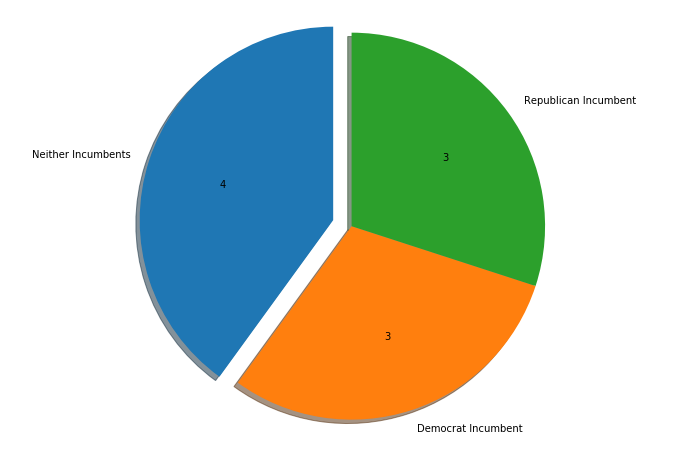

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

race_types = ["Neither Incumbents", "Democrat Incumbent", "Republican Incumbent"]
count_no_incumbs = df_pres.loc[df_pres['Incumbent'] == 0].shape[0]
count_dem_incumbs = df_pres.loc[df_pres['Incumbent'] == 1].shape[0]
count_rep_incumbs = df_pres.loc[df_pres['Incumbent'] == 2].shape[0]
race_counts = [count_no_incumbs, count_dem_incumbs, count_rep_incumbs]
# race_count_str = [str(count_dem_incumbs), str(count_rep_incumbs), str(count_no_incumbs)]

def func(lab):
    return str(round((lab/10), 0).astype(int))

fig_pie, ax_pie = plt.subplots(figsize=(12,8))
ax_pie.pie(race_counts, explode=(0.1,0,0), labels=race_types,
           autopct=lambda x: func(x), shadow=True, startangle=90)
ax_pie.axis('equal')

plt.show()

### What Campaigns Raised Per Voter

In an attempt to keep the numbers in perspective, the amounts a candidate raised will be divided by the number of votes recieved by that candidate.

### Presidential Races Without an Incumbent

In [18]:
df_pres_no_inc = df_pres.copy().loc[df_pres['Incumbent'] == 0, :]
df_pres_no_inc['RaisePerVote1'] = df_pres_no_inc['CampaignRaised1'] / df_pres_no_inc['PopularVote1']
df_pres_no_inc['RaisePerVote2'] = df_pres_no_inc['CampaignRaised2'] / df_pres_no_inc['PopularVote2']
df_pres_no_inc

,Year,Candidate1,Candidate2,Party1,Party2,Winner,CampaignRaised1,CampaignRaised2,PopularVote1,PopularVote2,Incumbent,RaisePerVote1,RaisePerVote2
7,1988,Dukakis M,Bush GH,Democrat,Republican,Bush GH,9.009656e+07,9.134962e+07,41809074,48886097,0,2.154952,1.868622
4,2000,Gore A,Bush GW,Democrat,Republican,Bush GW,1.331080e+08,1.936577e+08,50999897,50456002,0,2.609967,3.838150
2,2008,Obama B,McCain J,Democrat,Republican,Obama B,7.786430e+08,4.015371e+08,69456000,59934000,0,11.210593,6.699655
0,2016,Clinton H,Trump D,Democrat,Republican,Trump D,5.856991e+08,3.506684e+08,65844610,62979636,0,8.895171,5.567965


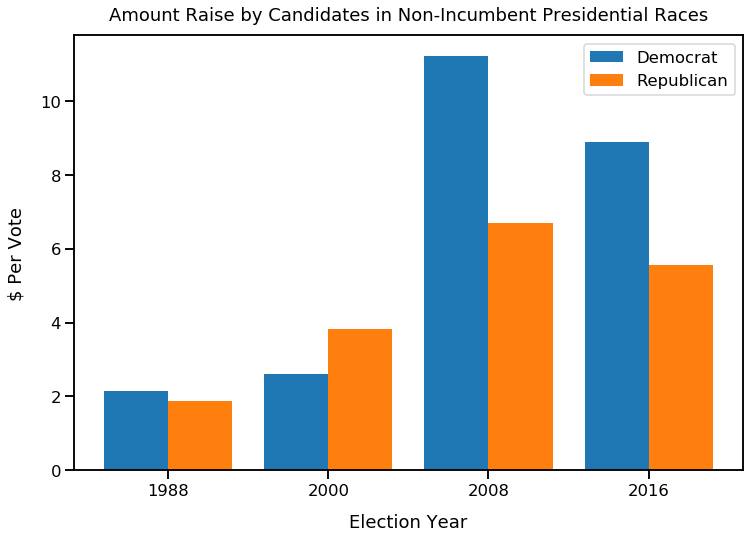

In [19]:
# https://www.pythoncharts.com/2019/03/26/grouped-bar-charts-matplotlib/
# Use Seaborn's context settings to make fonts larger.
import seaborn as sns
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(12,8))

bar_width = 0.4
x = np.arange(len(df_pres_no_inc['Year'].unique()))

b1 = ax.bar(x, df_pres_no_inc['RaisePerVote1'], width=bar_width, label="Democrat")
b2 = ax.bar(x + bar_width, df_pres_no_inc['RaisePerVote2'], width=bar_width, label="Republican")
# set the x-axis labels to the year of the election
ax.set_xticks(x + bar_width / 2)  # so labels are in the center of the grouping
ax.set_xticklabels(df_pres_no_inc['Year'].unique())

ax.legend()

ax.set_xlabel("Election Year", labelpad=15)
ax.set_ylabel("$ Per Vote", labelpad=15)
ax.set_title("Amount Raise by Candidates in Non-Incumbent Presidential Races", pad=15)

plt.show()

### Presidential Races With Democrat Incumbent

In [20]:
df_pres_dem_inc = df_pres.copy().loc[df_pres['Incumbent'] == 1, :]
df_pres_dem_inc['RaisePerVote1'] = df_pres_dem_inc['CampaignRaised1'] / df_pres_dem_inc['PopularVote1']
df_pres_dem_inc['RaisePerVote2'] = df_pres_dem_inc['CampaignRaised2'] / df_pres_dem_inc['PopularVote2']
df_pres_dem_inc

,Year,Candidate1,Candidate2,Party1,Party2,Winner,CampaignRaised1,CampaignRaised2,PopularVote1,PopularVote2,Incumbent,RaisePerVote1,RaisePerVote2
9,1980,Carter J,Reagan R,Democrat,Republican,Reagan R,1.982884e+07,6.294416e+07,35480948,43642639,1,0.558859,1.442263
5,1996,Clinton W,Dole R,Democrat,Republican,Clinton W,1.239358e+08,1.442709e+08,47402357,39198755,1,2.614549,3.680498
1,2012,Obama B,Romney M,Democrat,Republican,Obama B,7.426019e+08,4.836429e+08,65446032,60589084,1,11.346783,7.982344


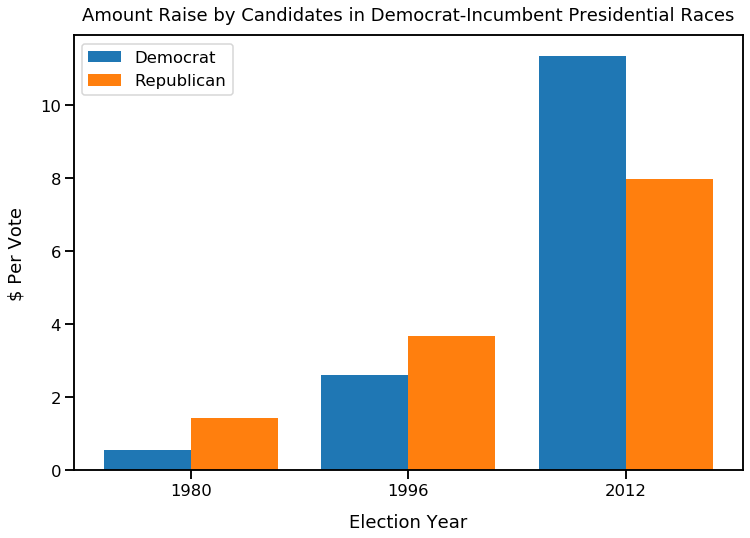

In [21]:
fig, ax = plt.subplots(figsize=(12,8))

bar_width = 0.4
x = np.arange(len(df_pres_dem_inc['Year'].unique()))

b1 = ax.bar(x, df_pres_dem_inc['RaisePerVote1'], width=bar_width, label="Democrat")
b2 = ax.bar(x + bar_width, df_pres_dem_inc['RaisePerVote2'], width=bar_width, label="Republican")
# set the x-axis labels to the year of the election
ax.set_xticks(x + bar_width / 2)  # so labels are in the center of the grouping
ax.set_xticklabels(df_pres_dem_inc['Year'].unique())

ax.legend()

ax.set_xlabel("Election Year", labelpad=15)
ax.set_ylabel("$ Per Vote", labelpad=15)
ax.set_title("Amount Raise by Candidates in Democrat-Incumbent Presidential Races", pad=15)

plt.show()

### Presidential Races With Republican Incumbent

In [22]:
df_pres_rep_inc = df_pres.copy().loc[df_pres['Incumbent'] == 2, :]
df_pres_rep_inc['RaisePerVote1'] = df_pres_rep_inc['CampaignRaised1'] / df_pres_rep_inc['PopularVote1']
df_pres_rep_inc['RaisePerVote2'] = df_pres_rep_inc['CampaignRaised2'] / df_pres_rep_inc['PopularVote2']
df_pres_rep_inc

,Year,Candidate1,Candidate2,Party1,Party2,Winner,CampaignRaised1,CampaignRaised2,PopularVote1,PopularVote2,Incumbent,RaisePerVote1,RaisePerVote2
8,1984,Mondale W,Reagan R,Democrat,Republican,Reagan R,8.287973e+07,7.647662e+07,37577185,54455075,2,2.205586,1.404398
6,1992,Clinton W,Bush GH,Democrat,Republican,Clinton W,1.152615e+08,1.019369e+08,44909889,39104545,2,2.566507,2.606779
3,2004,Kerry J,Bush GW,Democrat,Republican,Bush GW,3.515983e+08,3.778464e+08,59028109,62028285,2,5.956455,6.091518


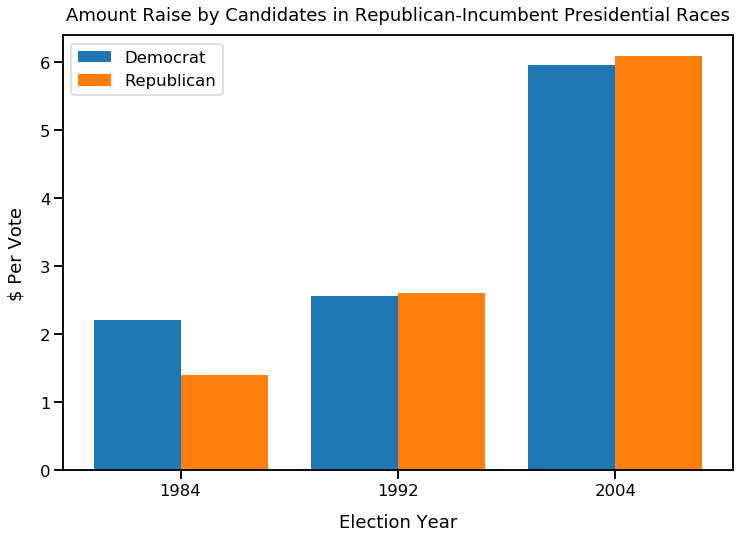

In [23]:
fig, ax = plt.subplots(figsize=(12,8))

bar_width = 0.4
x = np.arange(len(df_pres_rep_inc['Year'].unique()))

b1 = ax.bar(x, df_pres_rep_inc['RaisePerVote1'], width=bar_width, label="Democrat")
b2 = ax.bar(x + bar_width, df_pres_rep_inc['RaisePerVote2'], width=bar_width, label="Republican")
# set the x-axis labels to the year of the election
ax.set_xticks(x + bar_width / 2)  # so labels are in the center of the grouping
ax.set_xticklabels(df_pres_rep_inc['Year'].unique())

ax.legend()

ax.set_xlabel("Election Year", labelpad=15)
ax.set_ylabel("$ Per Vote", labelpad=15)
ax.set_title("Amount Raise by Candidates in Republican-Incumbent Presidential Races", pad=15)

plt.show()

### Presidential Difference Between Winner and Loser

In [24]:
df_pres['candidate1_win'] = (df_pres['Winner'] == df_pres['Candidate1']).astype(int)
df_pres['winner1_raised'] = df_pres['candidate1_win'] * df_pres['CampaignRaised1']
df_pres['winner2_raised'] = (~(df_pres['candidate1_win'].astype(bool))).astype(int) * \
                             df_pres['CampaignRaised2']
df_pres['winner_raised'] = df_pres['winner1_raised'] + df_pres['winner2_raised']
df_pres['loser_raised'] = df_pres['CampaignRaised1'] + df_pres['CampaignRaised2'] - \
                          df_pres['winner_raised']
# compute difference between what winner raise and loser raise
df_pres['raised_diff'] = (df_pres['winner_raised'] - df_pres['loser_raised']) / df_pres['winner_raised']
# compute the winning vote margin
df_pres['winner_vote_margin'] = (df_pres['PopularVote1'] - df_pres['PopularVote2']).abs()
# compute winner raised per winning vote margin
df_pres['diff_winner_loser_per_vote'] = df_pres['raised_diff'] / df_pres['winner_vote_margin']
df_pres

,Year,Candidate1,Candidate2,Party1,Party2,Winner,CampaignRaised1,CampaignRaised2,PopularVote1,PopularVote2,Incumbent,candidate1_win,winner1_raised,winner2_raised,winner_raised,loser_raised,raised_diff,winner_vote_margin,diff_winner_loser_per_vote
9,1980,Carter J,Reagan R,Democrat,Republican,Reagan R,1.982884e+07,6.294416e+07,35480948,43642639,1,0,0.000000e+00,6.294416e+07,6.294416e+07,1.982884e+07,0.684977,8161691,8.392590e-08
8,1984,Mondale W,Reagan R,Democrat,Republican,Reagan R,8.287973e+07,7.647662e+07,37577185,54455075,2,0,0.000000e+00,7.647662e+07,7.647662e+07,8.287973e+07,-0.083726,16877890,-4.960713e-09
7,1988,Dukakis M,Bush GH,Democrat,Republican,Bush GH,9.009656e+07,9.134962e+07,41809074,48886097,0,0,0.000000e+00,9.134962e+07,9.134962e+07,9.009656e+07,0.013717,7077023,1.938268e-09
6,1992,Clinton W,Bush GH,Democrat,Republican,Clinton W,1.152615e+08,1.019369e+08,44909889,39104545,2,1,1.152615e+08,0.000000e+00,1.152615e+08,1.019369e+08,0.115603,5805344,1.991328e-08
5,1996,Clinton W,Dole R,Democrat,Republican,Clinton W,1.239358e+08,1.442709e+08,47402357,39198755,1,1,1.239358e+08,0.000000e+00,1.239358e+08,1.442709e+08,-0.164078,8203602,-2.000071e-08
4,2000,Gore A,Bush GW,Democrat,Republican,Bush GW,1.331080e+08,1.936577e+08,50999897,50456002,0,0,0.000000e+00,1.936577e+08,1.936577e+08,1.331080e+08,0.312663,543895,5.748599e-07
3,2004,Kerry J,Bush GW,Democrat,Republican,Bush GW,3.515983e+08,3.778464e+08,59028109,62028285,2,0,0.000000e+00,3.778464e+08,3.778464e+08,3.515983e+08,0.069468,3000176,2.315458e-08
2,2008,Obama B,McCain J,Democrat,Republican,Obama B,7.786430e+08,4.015371e+08,69456000,59934000,0,1,7.786430e+08,0.000000e+00,7.786430e+08,4.015371e+08,0.484312,9522000,5.086238e-08
1,2012,Obama B,Romney M,Democrat,Republican,Obama B,7.426019e+08,4.836429e+08,65446032,60589084,1,1,7.426019e+08,0.000000e+00,7.426019e+08,4.836429e+08,0.348718,4856948,7.179786e-08
0,2016,Clinton H,Trump D,Democrat,Republican,Trump D,5.856991e+08,3.506684e+08,65844610,62979636,0,0,0.000000e+00,3.506684e+08,3.506684e+08,5.856991e+08,-0.670236,2864974,-2.339414e-07


In [26]:
years = df_pres['Year'].sort_values().astype(str).tolist()
years

['1980',
 '1984',
 '1988',
 '1992',
 '1996',
 '2000',
 '2004',
 '2008',
 '2012',
 '2016']

In [27]:
election_anns = ['Reagan beats Carter (I)', 'Reagan (I) beats Mondale', 'Bush beats Dukakis',
                 'Clinton beats Bush (I)', 'Clinton (I) beats Dole',' Bush beats Gore',
                 'Bush (I) beats Kerry', 'Obama beats McCain', 'Obama (I) beats Romney','Trump beats Clinton']
ann_colors = ['white','black','black',
              'black','black','black',
              'black','black','black','white']
# location of the text annotating each bar: center = center of the bar with white text
# above = above the y = 0
ann_locs = ['center','above','below','below','above','below','below','below','below','center']

def get_valign(y_val, h_val, ind, va_val, y_spacer = 0.05):
    """
    
    """
    ret_val = y_val + h_val/2
    if(ind == 0 or ind == 10):
        return (ret_val, va_val)
    else:
        if(va_val == 'above'):
            return (y_spacer, 'bottom')
        else:
            return (-y_spacer, 'top')
    
    

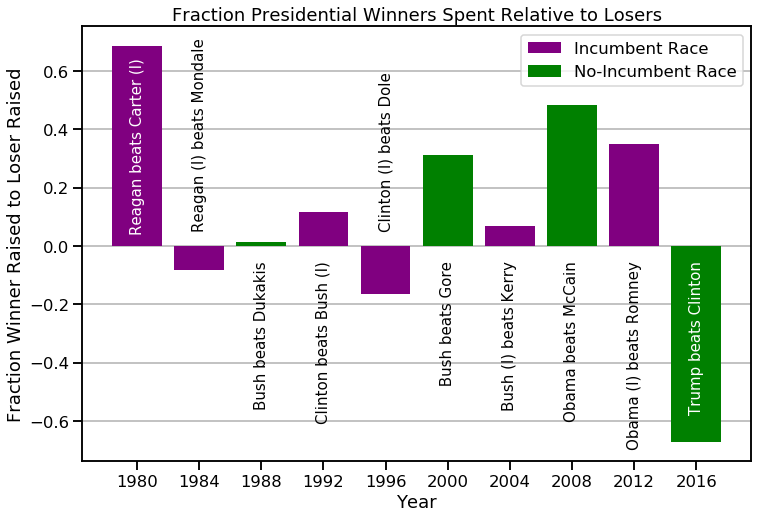

In [28]:
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(12,8))

bar_colors = ['purple','purple','green','purple','purple',
              'green','purple','green','purple','green']
ax.bar(years, df_pres['raised_diff'], color=bar_colors)
ax.set_title("Fraction Presidential Winners Spent Relative to Losers")
ax.set_ylabel("Fraction Winner Raised to Loser Raised")
ax.set_xlabel("Year")
ax.grid(axis='y')
ax.set_axisbelow(True)  # puts the grid in the background
# add labels to see who was running each election year
for i in range(len(ax.patches)):
    p = ax.patches[i]
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()  # bottom left x and y coord's 
    y_text_base = get_valign(y, height, i, ann_locs[i])[0]
    y_text_align = get_valign(y, height, i, ann_locs[i])[1]
    ax.text(x=x+width/2,
            y=y_text_base,  #y+height/2,
            s=election_anns[i],
            horizontalalignment='center',
            verticalalignment=y_text_align,
            color=ann_colors[i],
            rotation=90,
            size=15
           )
legend_elements = [Patch(facecolor='purple', label='Incumbent Race'),
                   Patch(facecolor='green', label='No-Incumbent Race')]

ax.legend(handles=legend_elements)
    
plt.show()

### Presidential Winner Spending Vs. Losers

In the last 10 presidential elections frm 1980 through 2016, winning presidential candidate outspend losers 7 out of those 10 elections (bars going up above 0).  Of the 7 races were the winner outspent the loser, 4 were no-incumbent races and 3 were againt an incumbent.  Of the 3 races where the loser outspent the winner (bars going down below 0), 1 was a no-incumbent race and 2 were against an incumbent.

It's not clear if there is a relationship between how much a winner outspends their opponent in an incumbent vs a no-incumbent race.  Let's take a look at some averages.

In [29]:
incumb_races = df_pres.copy().loc[df_pres['Incumbent'] > 0]
no_incumb_races = df_pres.copy().loc[df_pres['Incumbent'] == 0]
mean_incumb_outspend = incumb_races['raised_diff'].mean()
mean_no_incumb_outspend = no_incumb_races['raised_diff'].mean()

incumb_races.shape, no_incumb_races.shape, \
round(100. * mean_incumb_outspend, 2), round(100. * mean_no_incumb_outspend, 2)

((6, 19), (4, 19), 16.18, 3.51)

### Incumbent Winners Outspend Their Challengers On Average

Incumbent winners outspend their opponents on average of 16.2% compared to no-incumbent winners who outspent their opponents on average 3.5%.  The means are shown as white diamonds in the chart below.

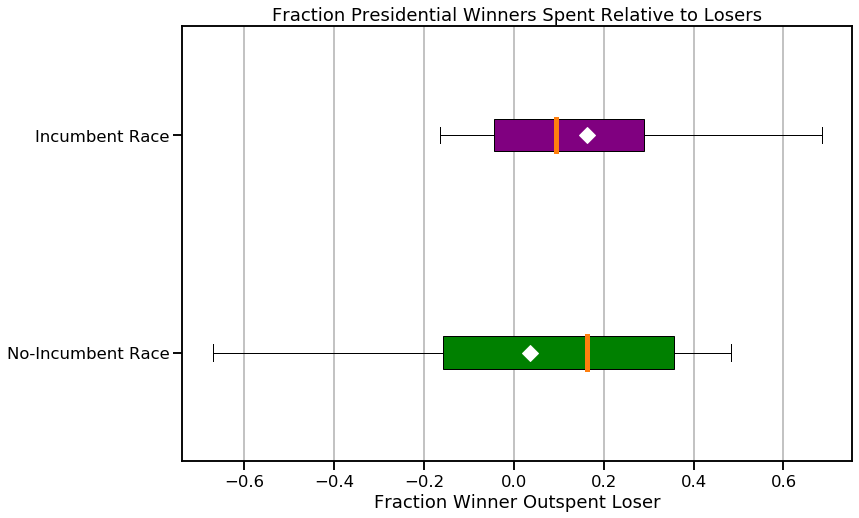

In [30]:
won_1_inc = np.array(incumb_races['raised_diff'])
won_0_inc = np.array(no_incumb_races['raised_diff'])
                     
fig, ax = plt.subplots(figsize=(12,8))

meanpointprops = dict(marker='D', markersize=12,
                      markeredgecolor='white',
                      markerfacecolor='white')
medianprops = dict(linewidth = 5)

box = ax.boxplot([won_0_inc, won_1_inc],
                 vert=False,
                 patch_artist=True,  # fill with color
                 showmeans = True,
                 labels=['No-Incumbent Race', 'Incumbent Race'],
                 medianprops=medianprops,
                 meanprops=meanpointprops)

box['boxes'][0].set_facecolor('green')
box['boxes'][1].set_facecolor('purple')

ax.set_xlabel('Fraction Winner Outspent Loser')
ax.set_title('Fraction Presidential Winners Spent Relative to Losers')
ax.grid(axis='x')
ax.set_axisbelow(True)


plt.show()

We can see from the above plot that the small sample size and the large variance suggests that the difference is not significant.  Run a t-test to verify this.

In [31]:
from scipy.stats import ttest_ind

ttest_ind(incumb_races['raised_diff'], no_incumb_races['raised_diff'])

Ttest_indResult(statistic=0.4941314932555203, pvalue=0.63449416465147)

Not too surprising that this difference is **not** significant.

### Prep Presidental Data for Modeling

In [44]:
pres_model_path = pres_dir + 'USPresidentialOverall2.csv'
df_pres_mod = pd.read_csv(pres_model_path, sep='\t')
df_pres_mod.head()

,Year,Candidate,Party,Won,Raised,isIncumbent,RaisedTop2Total
0,1980,Carter J,Democrat,0,19828843.0,1,82773007.0
1,1980,Reagan R,Republican,1,62944165.0,0,82773008.0
2,1984,Mondale W,Democrat,0,82879728.0,0,159356346.0
3,1984,Reagan R,Republican,1,76476619.0,1,159356347.0
4,1988,Dukakis M,Democrat,0,90096557.0,0,181446171.0


In [45]:
df_pres_mod['RaisedPortion'] = df_pres_mod['Raised'] / df_pres_mod['RaisedTop2Total']
df_pres_mod.head()

,Year,Candidate,Party,Won,Raised,isIncumbent,RaisedTop2Total,RaisedPortion
0,1980,Carter J,Democrat,0,19828843.0,1,82773007.0,0.239557
1,1980,Reagan R,Republican,1,62944165.0,0,82773008.0,0.760443
2,1984,Mondale W,Democrat,0,82879728.0,0,159356346.0,0.520091
3,1984,Reagan R,Republican,1,76476619.0,1,159356347.0,0.479909
4,1988,Dukakis M,Democrat,0,90096557.0,0,181446171.0,0.496547


### Logistic Regression of Presidential Data

What are we modeling?  The probability of winning given whether they are an incumbent **AND** what portion of the total they raised.  In terms of the variables we've been using, this can be written as:

$$
\large{p(\text{Won} = 1 \;| \;\text{isIncumbent}, \;\text{RaisedPortion})}
$$

In [49]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

form = 'Won ~ C(isIncumbent) + RaisedPortion'
logitfit = smf.logit(formula = str(form), data=df_pres_mod).fit()
logitfit.summary()

Optimization terminated successfully.
         Current function value: 0.466076
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    Won   No. Observations:                   20
Model:                          Logit   Df Residuals:                       17
Method:                           MLE   Df Model:                            2
Date:                Thu, 05 Dec 2019   Pseudo R-squ.:                  0.3276
Time:                        20:41:46   Log-Likelihood:                -9.3215
converged:                       True   LL-Null:                       -13.863
Covariance Type:            nonrobust   LLR p-value:                   0.01066
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -9.7455      4.409     -2.211      0.027     -18.386      -1.105
C(isIncumbent)[T.1]     2.9559      1.545      1.914      0.056      -0.072       5.983
RaisedPortion          17.2354      7.996      2.155      0.031       1.563      32.908
=======================================================================================
"""

### What the Presidential Logistic Regression Model Predictors Say about Election Results

Positive value for the `isIncumbent` predictor suggests that being an incumbent increases the odds of winning.

Positive value for the `RaisedPortion` predictor suggests that the greater the portion of the total a candidate raises, the more their odds of winning increase.

Though not covered in this this class, it should be mentioned that if we set Type 1 error to the typical value of 5% ($\alpha < 0.05$), the `RaisedPortion` would be significant, but the `isIncumbent` would not (but not by much).

### What the Model Would Have Predicted

It's interesting to see what probabilities the model assigned to each race. TODO

### Senate Races

The senate race data is structured differently than the presidential data

The `CAND_ICI` column indicates whether a candidate was and incumbent (I) or a challenger (C).  If the value was missing, it generally meant the candidate was a challenger.

In [34]:
df_sen_fixed['CAND_ICI'] = df_sen_fixed['CAND_ICI'].fillna('C')
df_sen_fixed.head()

,year,state_name,state,candidate,party_name,candidatevotes,totalvotes,Won,party,StripName,LastName,CAND_NAME,CAND_ICI,TTL_RECEIPTS
0,1980,Alabama,AL,Jeremiah Denton,republican,650362,1296757,1,REP,Jeremiah Denton,DENTON,"DENTON, JEREMIAH A",C,648167.0
1,1980,Alabama,AL,Jim Folsom Jr.,democrat,610175,1296757,0,DEM,Jim Folsom,FOLSOM,"FOLSOM, JIM JR",C,228746.0
2,1980,Alaska,AK,Frank H. Murkowski,republican,84159,156762,1,REP,Frank H. Murkowski,MURKOWSKI,"MURKOWSKI, FRANK H",C,527206.0
3,1980,Alaska,AK,Clark S. Gruening,democrat,72007,156762,0,DEM,Clark S. Gruening,GRUENING,"GRUENING, CLARK",C,512411.0
4,1980,Arizona,AZ,Barry Goldwater,republican,432371,874238,1,REP,Barry Goldwater,GOLDWATER,"GOLDWATER, BARRY M",I,908342.0


In [35]:
# Find which races had more than more or less than 2 competitors.
# SQL Server ROW_NUMBER() window function equivalent
df_sen_fixed['rank'] = \
  df_sen_fixed.copy().groupby(['year', 'state'])['candidatevotes'].rank(method='first',
                                                                        ascending=False).astype(int)
df_sen_fixed.head()

,year,state_name,state,candidate,party_name,candidatevotes,totalvotes,Won,party,StripName,LastName,CAND_NAME,CAND_ICI,TTL_RECEIPTS,rank
0,1980,Alabama,AL,Jeremiah Denton,republican,650362,1296757,1,REP,Jeremiah Denton,DENTON,"DENTON, JEREMIAH A",C,648167.0,1
1,1980,Alabama,AL,Jim Folsom Jr.,democrat,610175,1296757,0,DEM,Jim Folsom,FOLSOM,"FOLSOM, JIM JR",C,228746.0,2
2,1980,Alaska,AK,Frank H. Murkowski,republican,84159,156762,1,REP,Frank H. Murkowski,MURKOWSKI,"MURKOWSKI, FRANK H",C,527206.0,1
3,1980,Alaska,AK,Clark S. Gruening,democrat,72007,156762,0,DEM,Clark S. Gruening,GRUENING,"GRUENING, CLARK",C,512411.0,2
4,1980,Arizona,AZ,Barry Goldwater,republican,432371,874238,1,REP,Barry Goldwater,GOLDWATER,"GOLDWATER, BARRY M",I,908342.0,1


In [36]:
df_sen_qual = df_sen_fixed.copy().groupby(['year', 'state']).agg(
    race_ind = pd.NamedAgg(column='rank', aggfunc=sum),
    year_agg = pd.NamedAgg(column='year', aggfunc=min)
)

# df_sen_qual.drop('year', axis=1, inplace=True)
df_sen_qual[df_sen_qual['race_ind'] != 3]

,,race_ind,year_agg
year,state,,
1992,LA,1,1992
1996,AR,6,1996
2000,RI,6,2000
2004,AK,6,2004
2012,MA,6,2012


### More Manual Fixing

The 5 races above were manually fixed by:

+ 1992 LA, manually add Jon, Khachaturian data
+ 1996 AR, manually remove extra Y. Tim Hutchinson record
+ 2000 RI, manually remove extra Lincoln D. Chafee record
+ 2004 AK, manually remove extraneous Murkowski record
+ 2012 MA, manually remove extraneous Warren record

and the correct file saved as `df_sen_all_manually_fixed2.csv`

### Senate Races Without an Incumbent

In [37]:
df_pres_overall = pd.read_csv(pres_overall_path, sep='\t').sort_values(by=['Year'])
df_pres_overall.set_index('Year', inplace=True)
df_pres_overall.columns


Index(['Candidate1', 'Candidate2', 'Party1', 'Party2', 'Winner',
       'CampaignRaised1', 'CampaignRaised2', 'PopularVote1', 'PopularVote2',
       'Incumbent'],
      dtype='object')

In [38]:
# df_pres_overall['CampaignRaisedDem'] = pd.to_numeric(df_pres_overall['CampaignRaisedDem'], errors='coerce')
# df_pres_overall['CampaignRaisedRep'] = pd.to_numeric(df_pres_overall['CampaignRaisedRep'], errors='coerce')
# new_index = [i for i in range(0, df_pres_overall.shape[0])]
# df_pres_overall.reindex(new_index)
df_pres_overall.head()

,Candidate1,Candidate2,Party1,Party2,Winner,CampaignRaised1,CampaignRaised2,PopularVote1,PopularVote2,Incumbent
Year,,,,,,,,,,
1980,Carter J,Reagan R,Democrat,Republican,Reagan R,19828843.0,6.294416e+07,35480948,43642639,1
1984,Mondale W,Reagan R,Democrat,Republican,Reagan R,82879728.0,7.647662e+07,37577185,54455075,2
1988,Dukakis M,Bush GH,Democrat,Republican,Bush GH,90096557.0,9.134962e+07,41809074,48886097,0
1992,Clinton W,Bush GH,Democrat,Republican,Clinton W,115261535.0,1.019369e+08,44909889,39104545,2
1996,Clinton W,Dole R,Democrat,Republican,Clinton W,123935797.0,1.442709e+08,47402357,39198755,1


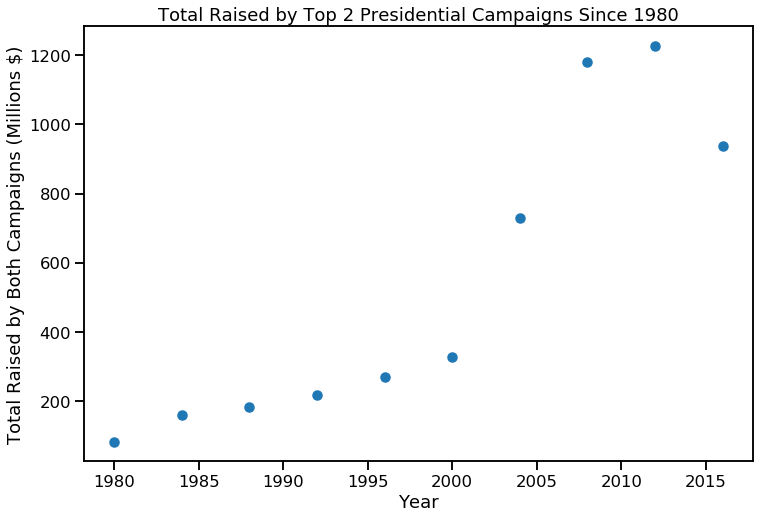

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(12,8))

ax.set_title("Total Raised by Top 2 Presidential Campaigns Since 1980")
ax.set_xlabel("Year")
ax.set_ylabel("Total Raised by Both Campaigns (Millions $)")

X = df_pres_overall.index
Y = (df_pres_overall['CampaignRaised1'] + df_pres_overall['CampaignRaised2']) / 1e06
ax.scatter(X, Y)

plt.show()

In [40]:
x_ind = np.arange(df_pres_overall.shape[0])  # x locations for the groups
bar_width = 0.35

# If these aren't wrapped by np.array(...), the I get this:
# TypeError: only size-1 arrays can be converted to Python scalars
# when I try to create the bar plot below.  Details of the fix are discussed here:
# https://stackoverflow.com/questions/21687581/
#         typeerror-only-length-1-arrays-can-be-converted-to-python-scalars-while-trying
dem_raise = np.array(df_pres_overall.copy().sort_values(by=['Year'])['CampaignRaised1'] / 1e09)
rep_raise = np.array(df_pres_overall.copy().sort_values(by=['Year'])['CampaignRaised2'] / 1e09)

dem_raise, rep_raise, dem_raise+rep_raise, type(dem_raise), type(rep_raise)

(array([0.01982884, 0.08287973, 0.09009656, 0.11526153, 0.1239358 ,
        0.13310804, 0.35159827, 0.77864296, 0.74260191, 0.58569906]),
 array([0.06294416, 0.07647662, 0.09134961, 0.1019369 , 0.14427092,
        0.19365773, 0.37784644, 0.40153714, 0.4836429 , 0.35066844]),
 array([0.08277301, 0.15935635, 0.18144617, 0.21719844, 0.26820672,
        0.32676577, 0.72944472, 1.1801801 , 1.22624481, 0.9363675 ]),
 numpy.ndarray,
 numpy.ndarray)

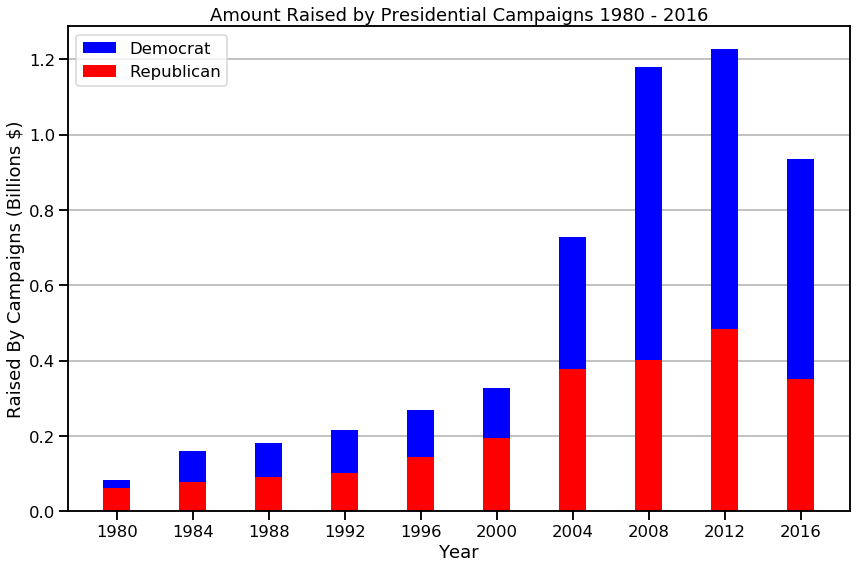

In [41]:
# grouped bar charts: https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/barchart.html
fig, ax = plt.subplots(figsize=(12,8))
# fig, ax = plt.subplots()
# left_bar = ax.bar(x_ind - bar_width/2, dem_raise, bar_width, label='Democrat')
# right_bar = ax.bar(x_ind + bar_width/2, rep_raise, bar_width, label='Republican')
# dem_bar = ax.bar(x_ind, dem_raise, bar_width,
#                  color='blue', label='Democrat')
dem_bar = ax.bar(x_ind, dem_raise, bar_width,
                 bottom=rep_raise, color='blue', label='Democrat')
rep_bar = ax.bar(x_ind, rep_raise, bar_width,
                 color='red', label='Republican')

ax.set_ylabel('Raised By Campaigns (Billions $)')
ax.set_xlabel('Year')
ax.set_title('Amount Raised by Presidential Campaigns 1980 - 2016')
ax.set_xticks(x_ind)
ax.set_xticklabels(df_pres_overall.index)
ax.legend(loc="upper left")
ax.grid(axis='y')
ax.set_axisbelow(True)

fig.tight_layout()

plt.show()

### TODO Items

+ Add 

### Date Sources

First 8 columns of presidential finance and election spreadsheet:  
https://www.fec.gov/data/raising-bythenumbers/

Columns 9 and 10 of the presidential finance and election spreadsheet:  
https://www.britannica.com/topic/United-States-Presidential-Election-Results-1788863

Historical US Senate election (see description provided near the top of the notebook):  
http://electionlab.mit.edu/
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/PEJ5QU

State-Level US Presidential Campaign Finance Data:  
https://www.fec.gov/data/raising-bythenumbers/


### Reference

1984 United States Senate election in Louisiana - https://en.wikipedia.org/wiki/1984_United_States_Senate_election_in_Louisiana

2004 United States Senate election in Idaho - https://en.wikipedia.org/wiki/2004_United_States_Senate_election_in_Idaho

SQL window function equivalents in pandas:  
https://dfrieds.com/data-analysis/rank-method-python-pandas  
https://stackoverflow.com/questions/17775935/sql-like-window-functions-in-pandas-row-numbering-in-python-pandas-dataframe

grouped bar charts - https://www.pythoncharts.com/2019/03/26/grouped-bar-charts-matplotlib/

Annotating Plots - https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/annotation_demo.html

T-Test in python - https://scientificallysound.org/2017/05/16/independent-t-test-python/

Horizontal box plots - http://www.datasciencemadesimple.com/box-plot-in-python/

Logistic Regression with statsmodels using the formula interface:
http://songhuiming.github.io/pages/2016/07/12/statsmodels-regression-examples/